## PH21 Assignment 5

In [1]:
######################################################
#                                                    #
#  Do not commit cache/data files to the repository  #
#                                                    #
######################################################

### In this assignment, you will need to do the following:

1. Determine the error bars on event count datasets
2. Use a collection of events to statistically test if a particle exists given a data channel
3. Fit a model of the particle and background events. Then test against a model with only the background events
3. Determine the likelihood that a particle exists using the errorbars generated from the event dataset.


Background
===========
In the previous assignments (including some of ph20) we have manipulated and fit against datasets where we have either ignored errorbars or had them given to us. Here we must determine the statistical error, given typical "counting statistics" present in all manner of physics experiments, though perhaps most prominently in High Energy Physics experiments using particle colliders.

motivating liturature:

If you are interested in some recent discoveries, take a look at the discovery of tetraquarks from LHCb: https://www.nature.com/articles/s41567-022-01614-y and its figure data at https://www.hepdata.net/record/114871. 

The figure to stare at is https://www.nature.com/articles/s41567-022-01614-y/figures/1.

similarly, look at a recent discovery of a Higgs boson decay channel through Z-gamma decays, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.132.021803. There, look at Figure 2 https://journals.aps.org/prl/article/10.1103/PhysRevLett.132.021803/figures/2/medium. A more complete history of its detection is given in https://pdg.lbl.gov/2022/reviews/rpp2022-rev-higgs-boson.pdf, which has many more similar plots.

What do both of these analysis have in common? The datasets are essentially plotting a Probability Distribution of event decays. What does that mean? Well a collider only sees the results of a collition as a big collection of resulting particles, their energy and their momentum (via where in the detector they were sensed). From data about the particles detected, various analysis methods "reconstruct" intermediate particles that led to the final observations. 

In the first paper, those intermediate observations were D- and Pi- Mesons. In the second paper, those were a pair of Z-boson and gamma (photon) particles. In both, the total energy of those particular choices of intermediate particles is plotted against the *rate* that events at that energy is seen. New particles tend to create an excess of events at an energy corresponding to the mass of the particle. The trick is to determine what choice of intermediates best detects it. We will assume those things, and just try to perform the detection, given a set of particle event data.

OK.... so how is that done? Well once those particles were reconstructed, essentially they were just put into a big histogram over the total energy of the resulting particles. By using simulation tools, the histograms for Higgs vs. No-higgs or tetra vs. no-tetra could be determined. 

With the data histogrammed, it then becomes a hypothesis test to determine which reality is the most likely. Likelihood is a statistical way of saying "in which reality is the observed data more probable."  

We will explore this using some simple examples, before looking at a dataset that mimics this Higgs channel discovery. I call it that since the Higgs was already discovered, but this newer result is a particularly clean example. 



In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#import mplhep as hep
import h5py as h5

from scipy.optimize import least_squares


Load the hdf5 dataset in collision_data.h5. Use h5py. The command line tool "h5ls -R file.h5" can be useful to explore, but you can also use python.

The data is a set of arrays forming a table of collision events. They are split into the individual particles recognized in the collider.

In [3]:
file = h5.File("collision_data.h5","r")

Make some preliminary histograms to explore the dataset. Transform the dataset into a histogram of the total collision energy. You can use your physics knowledge to try to further filter the data an remove backgrounds (the dataset was made "imperfect" so that there are some additional ways to distinguish background from events.). Further filtering is not necessary, but interesting to further reduce noise.

# Plotting the initial data
We simply read out the data from the file, and plot 6 relevant histograms regarding energy, azimuthal, and polar angles of the resulting Z boson and photon. We also plot a histogram of the summed energies of the two particles. We choose a bin size of 500, in order to ensure that the number of samples in each energy bin is still large, although this value can be varied without significant impact.

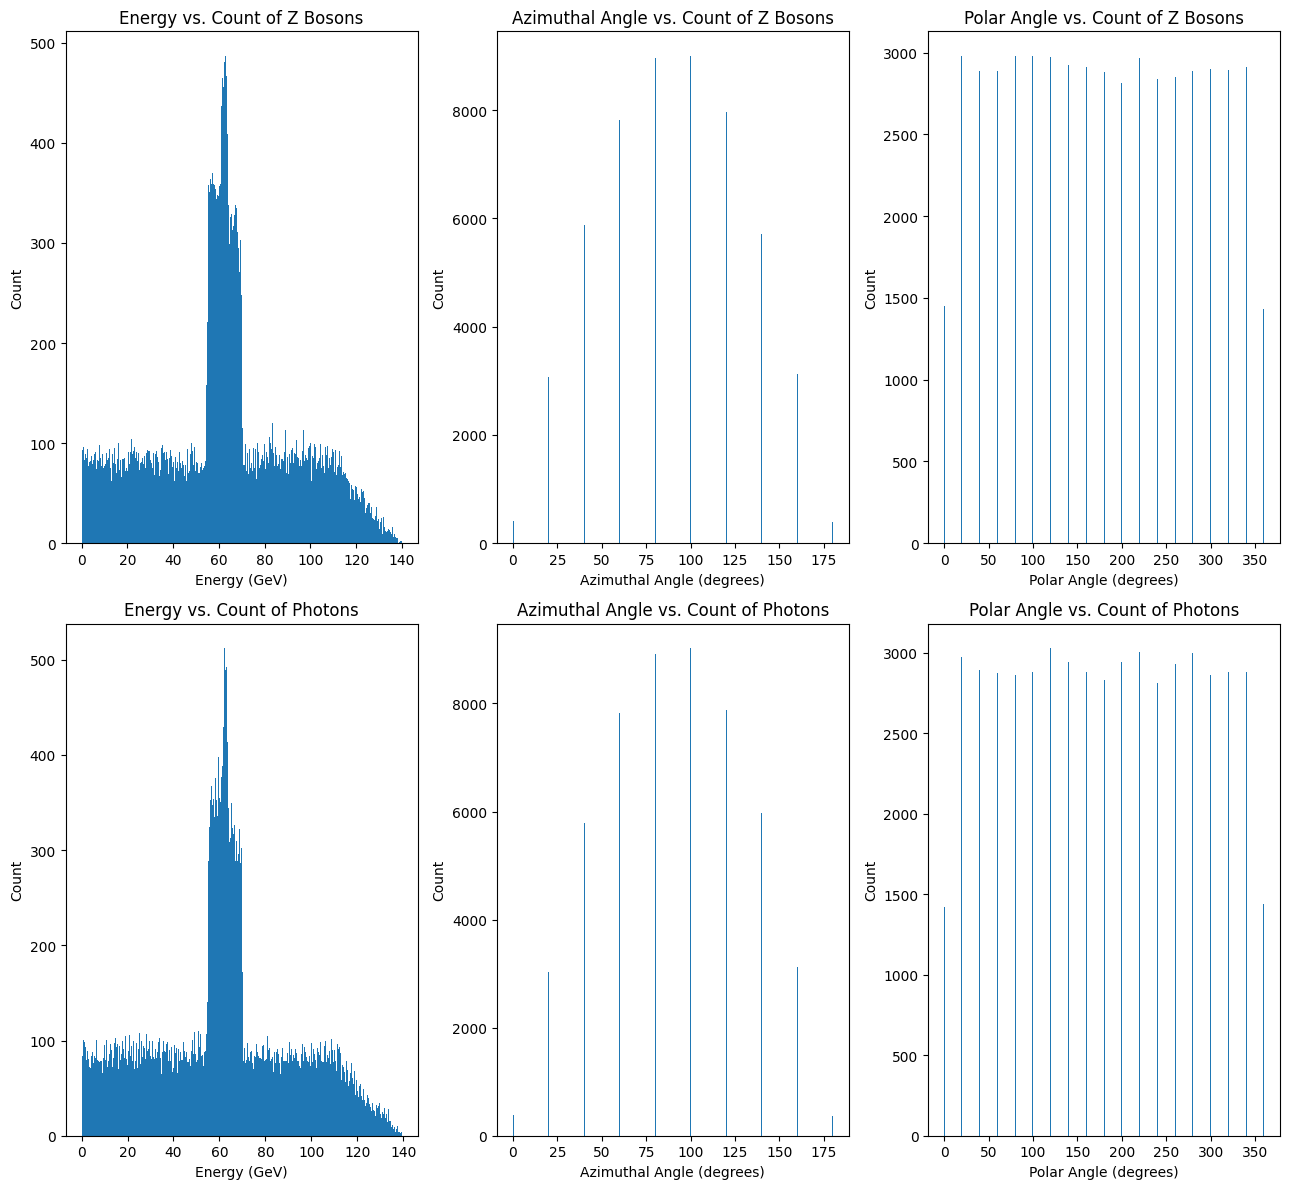

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(13, 12))

axs[0, 0].hist(list(file['Z_E_GeV']), bins=500)
axs[0, 0].set_title("Energy vs. Count of Z Bosons")
axs[0, 0].set_xlabel('Energy (GeV)')
axs[0, 0].set_ylabel('Count')

axs[0, 1].hist(list(file['Z_phi']), bins=500)
axs[0, 1].set_title("Azimuthal Angle vs. Count of Z Bosons")
axs[0, 1].set_xlabel('Azimuthal Angle (degrees)')
axs[0, 1].set_ylabel('Count')

axs[0, 2].hist(list(file['Z_theta']), bins=500)
axs[0, 2].set_title("Polar Angle vs. Count of Z Bosons")
axs[0, 2].set_xlabel('Polar Angle (degrees)')
axs[0, 2].set_ylabel('Count')

axs[1, 0].hist(list(file['gamma_E_GeV']), bins=500)
axs[1, 0].set_title(r"Energy vs. Count of Photons")
axs[1, 0].set_xlabel('Energy (GeV)')
axs[1, 0].set_ylabel('Count')

axs[1, 1].hist(list(file['gamma_phi']), bins=500)
axs[1, 1].set_title(r"Azimuthal Angle vs. Count of Photons")
axs[1, 1].set_xlabel('Azimuthal Angle (degrees)')
axs[1, 1].set_ylabel('Count')

axs[1, 2].hist(list(file['gamma_theta']), bins=500)
axs[1, 2].set_title(r"Polar Angle vs. Count of Photons")
axs[1, 2].set_xlabel('Polar Angle (degrees)')
axs[1, 2].set_ylabel('Count')

plt.tight_layout()

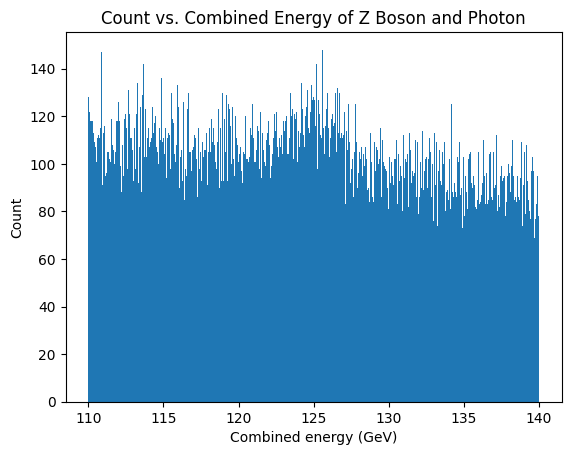

In [7]:
# Plotting the sum of the Z boson and photon energies
total_collision_energy = np.array(list(file['Z_E_GeV'])) + np.array(list(file['gamma_E_GeV']))
plt.ylabel("Count")
plt.xlabel("Combined energy (GeV)")
plt.title("Count vs. Combined Energy of Z Boson and Photon")

n, bins, patches = plt.hist(total_collision_energy, bins = 500)

Make a histogram in units of counts, and add the errorbars associated with Poisson counting error. You get to choose the binning you like. Explore the interactive example plots. Should the choice of binning matter?

# Counts and Error
The variance of a random variable drawn from a Poisson variable with Poisson parameter $\lambda$ is $\lambda$, and so the typical Poisson counting error is $\sqrt{\lambda}$. Therefore, we add an error bar of this magnitude (where $\lambda$ is the number of counts) for each energy bin. Later, when we calculate the likelihood ratio of the two models we fit, we will weigh the residuals by a factor of the reciprocal of the Poisson error. We will return to the issue of the choice of binning later, when we discuss the likelihood ratio in more depth.

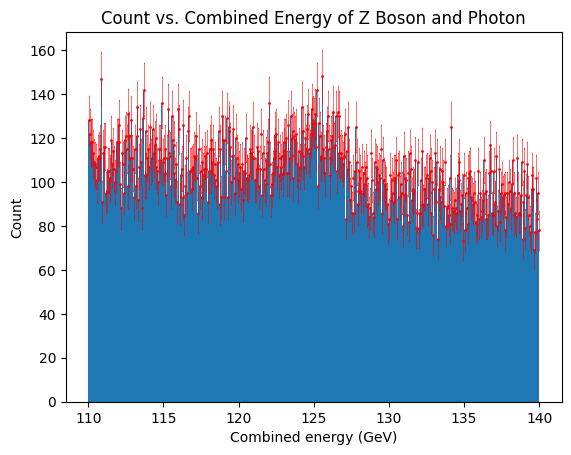

In [9]:
plt.ylabel("Count")
plt.xlabel("Combined energy (GeV)")
plt.title("Count vs. Combined Energy of Z Boson and Photon")
counts, bins, patches = plt.hist(total_collision_energy, bins = 500)

# Poisson errors are the square root of the number of counts
bin_centers = 0.5 * (bins[1:] + bins[:-1])
poisson_error = np.sqrt(counts)

error_bars = plt.errorbar(bin_centers, counts, yerr=poisson_error, fmt='o', markersize=1, elinewidth=0.4, capsize=0.25, color='red', label='Error bars')

Now calibrate the histogram and its errorbars into event rate units. This means cross-section per GeV of detected energy. The dataset was taken over an integrated luminosity of 
L = 150 fb^-1. That unit is inverse femto-barns. Yes, the barn is a unit of area in physics. It looks like a small area, but it is considered a large cross section. That means that every individual event in the dataset has a cross section of 1/L, and when you accumulate N of them, the cross section of the "pool" of events is N/L.

# Plan of Attack
We follow the advice given above, scaling the counts and the error bars by a factor of $\frac{1}{L}=\frac{1}{150}$.

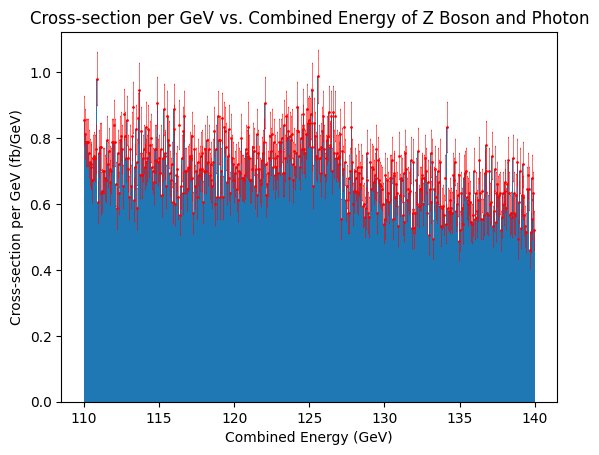

In [11]:
L = 150
# number of points per bin scaled by a factor of 1/L
cross_section = counts / L
# Poisson errors are the square root of the number of counts, scaled by a factor of L to maintain the same ratio
rescaled_poisson_error = poisson_error / L
plt.ylabel("Cross-section per GeV (fb/GeV)")
plt.xlabel("Combined Energy (GeV)")
plt.title("Cross-section per GeV vs. Combined Energy of Z Boson and Photon")

# plot a histogram with the number of points per bin (scaled by a factor of 1/L), with the poisson errors rescaled as well
plt.bar(bins[:-1], cross_section, width=bins[1] - bins[0], align='edge')
error_bars = plt.errorbar(bin_centers, cross_section, yerr=rescaled_poisson_error, fmt='o', markersize=1, elinewidth=0.4, capsize=0.25, color='red', label='Error bars')
plt.show()

Now create a model background and event process. The background can be a rate in the Lorenzian tail of many low-energy processes

$R_{bg}(E) = R_{scale} * \frac{E_{scale}}{E}$

$R_{higgs}(E) = \frac{1}{\pi}\frac{\Delta E}{\Delta E^2 + (E - mc^2)^2}$ 

$R_{joint}(E) = R_{bg}(E) + (A*B)*R_{higgs}(E)$

Where A is the Higgs formation cross section (units of area) and B is an unknown representing the branching ratio into the Higgs measurement channel of interest. Note that this measurement can only measure the product, so you can call that $C=(A \cdot B)$ which is the cross section for the $Z\gamma$ decay channel. $\Delta E$ in principle measures the lifetime/energy width of the Higgs, but here is limited by the resolution of the detection system, which smears out the event energies.

You will then create residuals by subtracting the data from the model and weighting by the error bars. Use scipy.optimize.least_squares to fit the unknown parameters of both the particle and backgrounds.

Perform this minimization twice, once using the joint rate, and once using a rate with only the background.

Plot all of these things together, and print all of the parameters.


## Creating the Model

Because $R_{scale}$ and $E_{scale}$ are multiplied together, we can treat them as one variable $R_0 = R_{scale}*E_{scale}$. Then, the problem of the joint rate amounts to fitting the 4 parameters $R_0$, $\Delta E$, $m$ and $C$ to the equations 

$R_{bg}(E) = \frac{R_0}{E}$

$R_{higgs}(E) = \frac{1}{\pi}\frac{\Delta E}{\Delta E^2 + (E - mc^2)^2}$ 

$R_{joint}(E) = R_{bg}(E) + C*R_{higgs}(E)$

where $\Delta E$ is the energy uncertainty of an intermediate particle, related to its lifetime before it decays, and $m$ is the mass of the intermediate particle.

For the background only, the process is even simpler -- we only have to fit the variable $R_0$, defined above.

Optimized parameters for joint rate:
R_0 = 83.58040
ΔE = -1.77758
m = 125.08176
C = -0.84365
Optimized parameters for background rate only:
R_0 = 86.78601


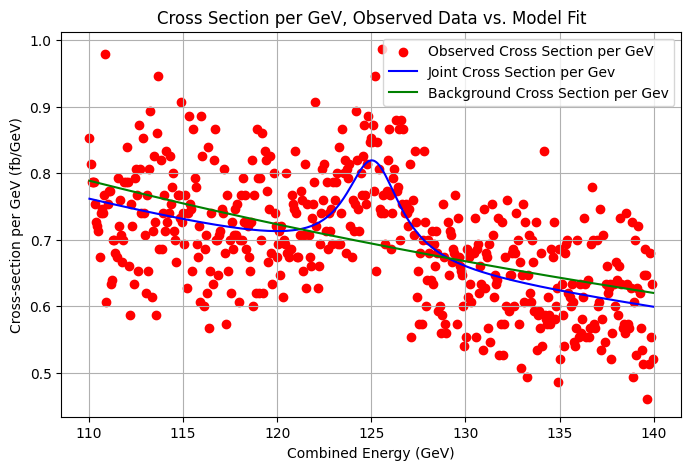

In [13]:
# For the joint rate, we fit four parameters: R_0, Delta_E, m, and C

def residuals_joint(params, E, observed_R):
    R_0, Delta_E, m, C = params  # Parameters to fit
    
    R_bg = R_0 / E
    R_higgs = (1 / np.pi) * (Delta_E / (Delta_E**2 + (E - m)**2))
    R_joint = R_bg + C * R_higgs
    
    return R_joint - observed_R 

def residuals_bg(params, E, observed_R):
    R_0 = params 
    
    R_bg = R_0 / E
    
    return R_bg - observed_R 
    
initial_guess_joint = [100, 10, 125, 0.1]  
initial_guess_bg = [100]

# Perform least squares fitting
E_values = (bins[:-1] + bins[1:]) / 2
joint = least_squares(residuals_joint, initial_guess_joint, args=(E_values, cross_section))
bg = least_squares(residuals_bg, initial_guess_bg, args=(E_values, cross_section))

# Extract optimized parameters
R_0_opt_joint, Delta_E_opt_joint, m_opt_joint, C_opt_joint = joint.x
R_0_opt_bg = bg.x[0]

# Print results
print("Optimized parameters for joint rate:")
print(f"R_0 = {R_0_opt_joint:.5f}")
print(f"ΔE = {Delta_E_opt_joint:.5f}")
print(f"m = {m_opt_joint:.5f}")
print(f"C = {C_opt_joint:.5f}")

print("Optimized parameters for background rate only:")
print(f"R_0 = {R_0_opt_bg:.5f}")

# Compute fitted curves using optimized parameters
R_bg_fit_joint = R_0_opt_joint / E_values
R_higgs_fit_joint = (1 / np.pi) * (Delta_E_opt_joint / (Delta_E_opt_joint**2 + (E_values - m_opt_joint)**2))
R_joint_fit_joint = R_bg_fit_joint + C_opt_joint * R_higgs_fit_joint

R_bg_fit_bg = R_0_opt_bg / E_values

# Plot actual data vs. fitted function
plt.figure(figsize=(8, 5))
plt.scatter(E_values, cross_section, color='red', label="Observed Cross Section per GeV")
plt.plot(E_values, R_joint_fit_joint, color='blue', label="Joint Cross Section per Gev")
plt.plot(E_values, R_bg_fit_bg, color='green', label="Background Cross Section per Gev")

plt.xlabel("Combined Energy (GeV)")
plt.ylabel("Cross-section per GeV (fb/GeV)")
plt.legend()
plt.title("Cross Section per GeV, Observed Data vs. Model Fit")
plt.grid()
plt.show()

Now get the array of residuals for both fits. This array has a statistical interpretation. Each data point represents a random variable. In the low-N limit, this variable has a binomial distribution. If you used very fine binning, you may have to consider that. For course binning, the N in each bit is large, N>30, where the central limit theorem kicks in and the Binomial distribution can be approximated as a Gaussian with a standard deviation equal to the error bar. Since the residuals are normalized by the error bar, they should look like standard normal distributions.

Histogram the residuals of each fit and check that they appear Gaussian distributed with the correct scaling. (You could in principle put error bars on this histogram too.. and that is useful to test the Guassianaity of your noise process. No need here). This is a very standard data quality test to check an error model

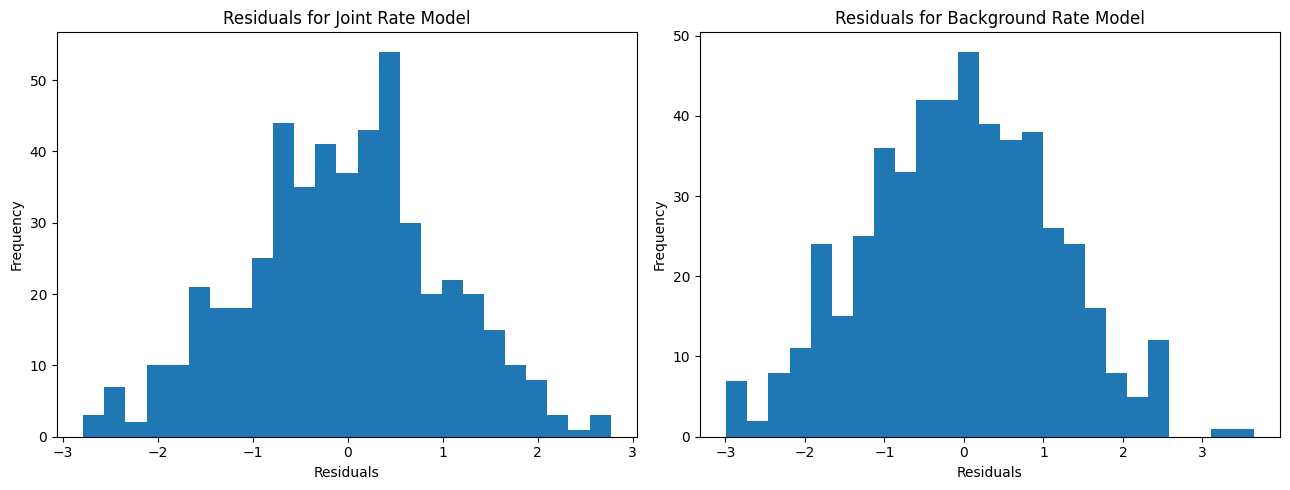

In [15]:
# Calculate residuals, scaled by the Poisson error
residuals_values_joint = (cross_section - R_joint_fit_joint) / rescaled_poisson_error
residuals_values_bg = (cross_section - R_bg_fit_bg) / rescaled_poisson_error 

# Create a figure and two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# First subplot for joint residuals
axs[0].hist(residuals_values_joint, bins=25)
axs[0].set_xlabel("Residuals")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Residuals for Joint Rate Model")

# Second subplot for background residuals
axs[1].hist(residuals_values_bg, bins=25)
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Residuals for Background Rate Model")

# Display the side-by-side histograms
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Observations on the Residual Plots
Both of these residual plots appear relatively Gaussian. The bulk of both plots is located within one, and certainly within two standard deviations, and the shape of both plots are approximately bell shaped.

Now, we want to determine the probability of either measurement. Since each residual represents a random normal value, you can plug it into the Gaussian distribution and get its probability. The total probability is the product. Note that for both measurements, this will seem like a tiny number! In fact, as you take more and more measurements, the probability of any observation gets smaller. Two things help: A) compute the log of the probability. This means just don't evaluate the exponential in the normal distribution (or do, but then log it). You can then sum to logs to find the total log-likelihood of either measurement. B) Now what we want to test is simply which measurement is relatively more likely. This is done by taking the ratio of the likelihoods, or the difference of the logs.

https://en.wikipedia.org/wiki/Likelihood-ratio_test (technically, this is not a simple hypothesis test, since we also fit parameters, but assume it is "Case of simple hypotheses")

The associated Neyman–Pearson lemma indicates that the likelihood ratio test is an optimal statistic, which means that you might as well do it this way. This test is great because it works well even for more complex distributions than Gaussians, and also works when the distributions are experimentally determined or modelled using sampling (a topic for ph22).

Interestingly, once you take the ratio, or difference of the logs, this issue that either/both measurements seem less likely with more data or more residuals goes away. This is like renormalization for statisticitians. It occurs because much of the data is only sensitive to the background model, which is common between the two hypotheses. Thus if each reality appears less likely due to more data, only the contribution where the probability model changes doesn't subtract away.

The actual statistical test is to set a threshold for the likelyhood ratio. To do that, you need to establish a model of the probability distribution of the likelihood ratio itself, assuming the null hypothesis (here, the Background-only no-Higgs rate model).

We aren't going to do that here. An exact derivation would find that the distribution of the likelyhood ratio is related to the https://en.wikipedia.org/wiki/Chi-squared_distribution. It isn't exactly related, since the likelyhood ratio implicitly uses an *optimal weighting* of the data (this is really cool). The optimal weighting indicates that the effective number of degress of freedom is fractional.

The more typical thing done in experiments is to then randomly sample and create fake virtual datasets with which to make histograms of the likelihood ratio! That way noone needs fancy computations, and indeed exceedingly complex interractions between physics, statistics, and measurement biases can all be accounted for.

That's a long lesson.. For this relatively simple Guassian residuals model, compute the log-likelihood ratio. That will also be the square of the standard error of the final distribution. Thus if you take the square root, you'll get the significance, in standard deviations. Hopefully your measurement of the Higgs is over 5-sigma (log likelihood ratio threshold of 25).

## Likelihood

For the likelihood of both the joint rate and the background rate only, we will take a Gaussian. Each of the 500 energy bins we used initially is associated with some Poisson noise $\sigma_j$. The probability density function of each individual prediction frequency bin $f_{j,pred}$ is then $$f(f_{j,obs})\propto \exp{\left(-\frac{1}{2}\frac{(f_{j,obs}-f_{j,pred})^2}{\sigma_j^2}\right)}.$$ This means that the probability of a given sequence of observations $\mathbf{v_{obs}}$, assuming that the observations are independence, is given as $$p(\mathbf{f_{obs}})\propto\prod_{j}f(f_{j,obs})$$ and the relevant log-likelihood is given as $$L(\mathbf{f_{obs}})=-\frac{1}{2}\sum_j\frac{(f_{j,obs}-f_{j,pred})^2}{\sigma_j^2}+C,$$ which is clearly related to the sum of squared distances between the predicted and observed distributions. When taking the relative log-likelihood, this factor of $C$ disappears.

Empirically, we will see the choice of binning has no significant difference for the relative log-likelihood. This is despite the fact that the absolute log-likelihoods of the data given each individual model does vary.

In [17]:
# Calculate log-likelihood for the two models. The residual values have already been scaled by a factor of the Poisson error.

log_likelihood_joint = -0.5 * np.sum(residuals_values_joint**2)
log_likelihood_bg = -0.5 * np.sum(residuals_values_bg**2)

# Calculate the relative log-likelihood
relative_log_likelihood = log_likelihood_joint - log_likelihood_bg

print(f"Relative Log-Likelihood: {relative_log_likelihood}")
print("Significance: " + str(np.sqrt(relative_log_likelihood)) + " standard deviations")

Relative Log-Likelihood: 74.6635374766837
Significance: 8.640806529293645 standard deviations


## Bin Sizes, Again

When $250$ bins are used, the relative log-likelihood of the two models is $72.14$. When $500$ bins are used (as above), the relative log-likelihood is $74.66$. When $1000$ bins are used, the relative log-likehood is $76.20$. This is remarkably constant, given that the log-likelihoods for each model essentially becomes more negative each time the number of bins doubles. I tried for a while to theoretically derive this result, using the fact that the log-likelihood estimate described above follows a $\chi^2$ sum. Unfortunately, I was unable to mathematically prove this, but the empirical evidence that bin size does not substantially affect relative log-likelihood is clear. 

# Conclusion
We see that the relative log-likelihood of the joint rate model is greater than $25$; that is, the likelihood of observing the data that we observed is more than $5\sigma$ greater if we postulate the existence of the Higgs process than if we just keep the background process. Thus, this is strong experimental evidence for the Higgs Boson.